In [5]:
import pandas as pd
import pyarrow
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt 
import seaborn as sns 
import yfinance as yf 
import yahoo_fin.stock_info as si 
from bs4 import BeautifulSoup 
from yahoo_fin.stock_info import get_analysts_info
import mplfinance as mpf
import requests
import json

# Get earnings history

In [2]:
df = pd.read_csv('earnings.csv', index_col='reportedDate', parse_dates=True)
df

,reportedEPS,estimatedEPS,surprise,surprisePercentage
reportedDate,,,,
2024-02-01,2.0200,1.93,0.0900,4.6632
2023-11-02,1.4600,1.39,0.0700,5.0360
2023-08-03,1.2600,1.19,0.0700,5.8824
2023-05-04,1.5200,1.43,0.0900,6.2937
2023-02-02,1.8800,1.94,-0.0600,-3.0928
...,...,...,...,...
1997-04-16,-0.0500,-0.04,-0.0100,-25.0000
1997-01-15,-0.0300,-0.02,-0.0100,-50.0000
1996-10-16,0.0018,-0.01,0.0118,118.0000


In [3]:
def downcast_columns(df, cols):
    df = df.copy()  # Doesn't modify original DF
    df[cols] = df[cols].astype('float16')
    return df

In [4]:
columns_to_downcast = ['reportedEPS', 'estimatedEPS', 'surprise', 'surprisePercentage']
df = downcast_columns(df, columns_to_downcast)

### Plot estimated and reported earnings

In [6]:
df_eps_plot = df[['estimatedEPS', 'reportedEPS']]

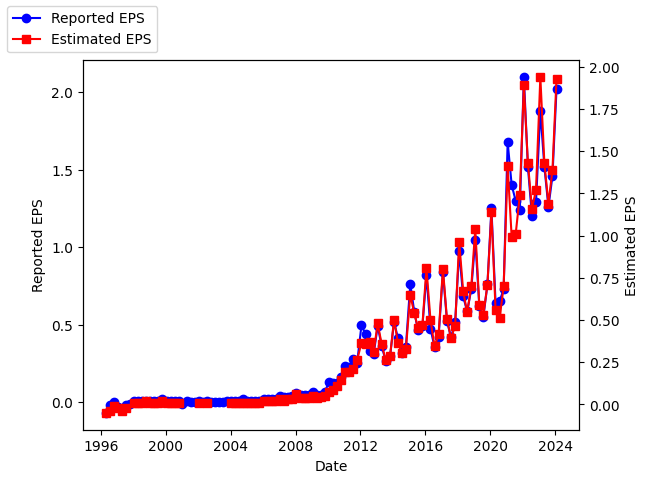

In [8]:
# Plot
fig, ax1 = plt.subplots()

# Plot reportedEPS
ax1.plot(df_eps_plot.index, df_eps_plot['reportedEPS'], color='b', marker='o', label='Reported EPS')
ax1.set_xlabel('Date')
ax1.set_ylabel('Reported EPS')
ax1.tick_params(axis='y')

# Create a twin Axes sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot(df_eps_plot.index, df_eps_plot['estimatedEPS'], color='r', marker='s', label='Estimated EPS')
ax2.set_ylabel('Estimated EPS')
ax2.tick_params(axis='y')

fig.legend(loc='upper left')


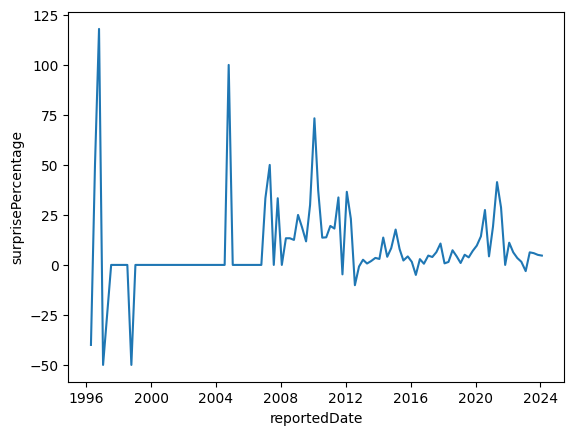

In [9]:
sns.lineplot(data=df['surprisePercentage']);

# Get stock price history

In [23]:
sp_data = pd.read_csv('Data/AAPL_price.csv')
sp_data

,Date,Open,High,Low,Adj Close,Volume
0,4/23/2008,5.858929,5.887143,5.752857,4.931376,1504190800
1,4/24/2008,5.905000,6.070714,5.685357,5.114537,1696066400
2,4/25/2008,6.096429,6.110714,5.943571,5.138454,992474000
3,4/28/2008,6.062500,6.205357,6.040357,5.214443,787214400
4,4/29/2008,6.111071,6.273571,6.080357,5.299513,923476400
...,...,...,...,...,...,...
3965,1/24/2024,195.419998,196.380005,194.339996,194.500000,53631300
3966,1/25/2024,195.220001,196.270004,193.110001,194.169998,54822100
3967,1/26/2024,194.270004,194.759995,191.940002,192.419998,44553400
3968,1/29/2024,192.009995,192.199997,189.580002,191.729996,47145600


In [24]:
sp_data.Date = pd.to_datetime(sp_data.Date)
sp_data = sp_data.set_index('Date')
sp_data.rename({'Adj Close': 'Close'}, axis=1, inplace=True)
sp_data


,Open,High,Low,Close,Volume
Date,,,,,
2008-04-23,5.858929,5.887143,5.752857,4.931376,1504190800
2008-04-24,5.905000,6.070714,5.685357,5.114537,1696066400
2008-04-25,6.096429,6.110714,5.943571,5.138454,992474000
2008-04-28,6.062500,6.205357,6.040357,5.214443,787214400
2008-04-29,6.111071,6.273571,6.080357,5.299513,923476400
...,...,...,...,...,...
2024-01-24,195.419998,196.380005,194.339996,194.500000,53631300
2024-01-25,195.220001,196.270004,193.110001,194.169998,54822100
2024-01-26,194.270004,194.759995,191.940002,192.419998,44553400


### Plot stock price and volume history

c:\Users\Scott\Git-Stock\Stock\.venv\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


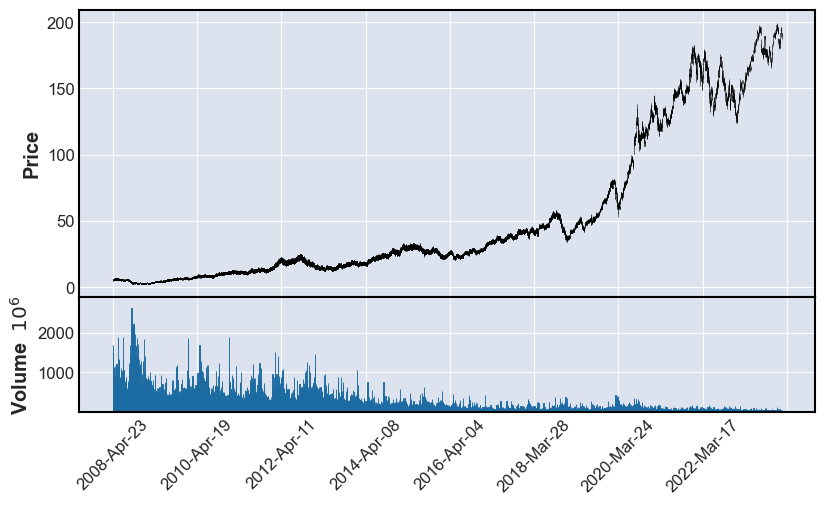

In [25]:
mpf.plot(sp_data, type='candle',volume=True, figratio=(16,9))

# Combine earnings and stock price data

In [6]:
price_earnings = pd.read_csv('Data/AAPL_price_earnings.csv', index_col='Date')
price_earnings

,Unnamed: 0,Open,High,Low,Close,Volume,reportedEPS,estimatedEPS,surprise,surprisePercentage
Date,,,,,,,,,,
2/5/2024,0,188.149994,189.250000,185.839996,187.679993,69668800,2.02,1.93,0.09,4.6632
2/2/2024,1,179.860001,187.330002,179.250000,185.850006,102518000,2.02,1.93,0.09,4.6632
2/1/2024,2,183.990005,186.949997,183.820007,186.860001,64885400,2.02,1.93,0.09,4.6632
1/31/2024,3,187.039993,187.100006,184.350006,184.399994,55467800,1.46,1.39,0.07,5.0360
1/30/2024,4,190.940002,191.800003,187.470001,188.039993,55859400,1.46,1.39,0.07,5.0360
...,...,...,...,...,...,...,...,...,...,...
1/23/2007,4288,3.061786,3.125357,3.053929,2.594505,1207424400,0.04,0.03,0.01,33.3333
1/22/2007,4289,3.183571,3.184286,3.058929,2.627504,1454026000,0.04,0.03,0.01,33.3333
1/19/2007,4290,3.165357,3.201786,3.147143,2.679273,1364473600,0.04,0.03,0.01,33.3333


In [7]:
price_earnings.pop('Unnamed: 0')

Date
2/5/2024        0
2/2/2024        1
2/1/2024        2
1/31/2024       3
1/30/2024       4
             ... 
1/23/2007    4288
1/22/2007    4289
1/19/2007    4290
1/18/2007    4291
1/17/2007    4292
Name: Unnamed: 0, Length: 4293, dtype: int64

In [8]:
price_earnings['Tomorrow'] = price_earnings['Close'].shift(-1)
price_earnings['Target'] = (price_earnings['Tomorrow'] > price_earnings['Close']).astype(int)
price_earnings

,Open,High,Low,Close,Volume,reportedEPS,estimatedEPS,surprise,surprisePercentage,Tomorrow,Target
Date,,,,,,,,,,,
2/5/2024,188.149994,189.250000,185.839996,187.679993,69668800,2.02,1.93,0.09,4.6632,185.850006,0
2/2/2024,179.860001,187.330002,179.250000,185.850006,102518000,2.02,1.93,0.09,4.6632,186.860001,1
2/1/2024,183.990005,186.949997,183.820007,186.860001,64885400,2.02,1.93,0.09,4.6632,184.399994,0
1/31/2024,187.039993,187.100006,184.350006,184.399994,55467800,1.46,1.39,0.07,5.0360,188.039993,1
1/30/2024,190.940002,191.800003,187.470001,188.039993,55859400,1.46,1.39,0.07,5.0360,191.729996,1
...,...,...,...,...,...,...,...,...,...,...,...
1/23/2007,3.061786,3.125357,3.053929,2.594505,1207424400,0.04,0.03,0.01,33.3333,2.627504,1
1/22/2007,3.183571,3.184286,3.058929,2.627504,1454026000,0.04,0.03,0.01,33.3333,2.679273,1
1/19/2007,3.165357,3.201786,3.147143,2.679273,1364473600,0.04,0.03,0.01,33.3333,2.696529,1


### Data wrangling

In [15]:
def downcast_cols(price_earnings, cols):
    price_earnings = price_earnings.copy()  # Doesn't modify original DF
    price_earnings[cols] = price_earnings[cols].astype('float16')
    return price_earnings

In [17]:
cols_to_downcast = ['Open', 'High', 'Low', 'Close', 'estimatedEPS',	'surprise', 'surprisePercentage', 'Tomorrow']
price_earnings = downcast_cols(price_earnings, cols_to_downcast)

In [21]:
price_earnings['reportedEPS'] = pd.to_numeric(price_earnings['reportedEPS'], errors='coerce')
price_earnings['reportedEPS'] = price_earnings['reportedEPS'].astype('float16')
price_earnings['Target'] = price_earnings['Target'].astype('int8')

### ML - Random Forest Classifier

In [23]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = price_earnings.iloc[:-500]
test = price_earnings.iloc[-500:]

predictors = ['Open', 'High', 'Low', 'Close', 'Volume']
model.fit(train[predictors], train['Target'])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [24]:
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)

In [25]:
precision_score(test['Target'], preds)

0.5182724252491694

In [26]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['Target'])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name='Predictions')
    combined = pd.concat([test['Target'], preds], axis=1)
    return combined

In [27]:
def backtest(data, model, predictors, start=1250, step=250):
    all_predictions = []
    
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions) 

In [28]:
predictions = backtest(price_earnings, model, predictors)

In [29]:
predictions['Predictions'].value_counts()

Predictions
1    1727
0    1316
Name: count, dtype: int64

In [30]:
precision_score(predictions['Target'], predictions['Predictions'])

0.49797336421540245

In [31]:
predictions['Target'].value_counts() / predictions.shape[0]

Target
0    0.530069
1    0.469931
Name: count, dtype: float64

In [32]:
horizons = [2,5,21,63, 126] # of trading days
new_predictors = []

for horizon in horizons:
    rolling_averages = price_earnings.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    price_earnings[ratio_column] = price_earnings['Close'] / rolling_averages['Close']
    
    trend_column = f"Trend{horizon}"
    price_earnings[trend_column] = price_earnings.shift(1).rolling(horizon).sum()['Target']
    
    new_predictors += [ratio_column, trend_column]

### Modified model parameters

In [43]:
#Modified model parameters
model = RandomForestClassifier(n_estimators=300, min_samples_split=50, random_state=1)

In [44]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['Target'])
    preds = model.predict_proba(test[predictors])[:,1] #returns 0 or 1 @ 50%
    preds[preds >= .6] = 1 #raising threshold to 60%
    preds[preds <= .6] = 0
    preds = pd.Series(preds, index=test.index, name='Predictions')
    combined = pd.concat([test['Target'], preds], axis=1)
    return combined

In [45]:
predictions = backtest(price_earnings, model, new_predictors)

In [46]:
#Predict price going up (1) or down (0) based on 60% threshold
predictions['Predictions'].value_counts()

Predictions
0.0    2885
1.0     158
Name: count, dtype: int64

In [47]:
precision_score(predictions['Target'], predictions['Predictions'])

0.6012658227848101